## BE
- [Kaggle](https://www.kaggle.com/datasets/walterconway/covid-flu-cold-symptoms/data)

1. Data Preprocessing

In [1]:
# Import all the necessary libraries for data cleaning and machine learning algorithms (decision tree)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib as joblib

In [2]:
# df = pd.read_csv('large_flu_data.csv')
df = pd.read_csv('large_data.csv')

# Drop rows that are not type of FLU
df = df[df['TYPE'] == 'FLU']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 19453 to 44452
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   COUGH                 25000 non-null  int64 
 1   MUSCLE_ACHES          25000 non-null  int64 
 2   TIREDNESS             25000 non-null  int64 
 3   SORE_THROAT           25000 non-null  int64 
 4   RUNNY_NOSE            25000 non-null  int64 
 5   STUFFY_NOSE           25000 non-null  int64 
 6   FEVER                 25000 non-null  int64 
 7   NAUSEA                25000 non-null  int64 
 8   VOMITING              25000 non-null  int64 
 9   DIARRHEA              25000 non-null  int64 
 10  SHORTNESS_OF_BREATH   25000 non-null  int64 
 11  DIFFICULTY_BREATHING  25000 non-null  int64 
 12  LOSS_OF_TASTE         25000 non-null  int64 
 13  LOSS_OF_SMELL         25000 non-null  int64 
 14  ITCHY_NOSE            25000 non-null  int64 
 15  ITCHY_EYES            25000 non-null 

checking missing values

In [3]:
df.isna().sum()

COUGH                   0
MUSCLE_ACHES            0
TIREDNESS               0
SORE_THROAT             0
RUNNY_NOSE              0
STUFFY_NOSE             0
FEVER                   0
NAUSEA                  0
VOMITING                0
DIARRHEA                0
SHORTNESS_OF_BREATH     0
DIFFICULTY_BREATHING    0
LOSS_OF_TASTE           0
LOSS_OF_SMELL           0
ITCHY_NOSE              0
ITCHY_EYES              0
ITCHY_MOUTH             0
ITCHY_INNER_EAR         0
SNEEZING                0
PINK_EYE                0
TYPE                    0
dtype: int64

counting & cleaning feature values

In [4]:
cols = df.columns

for col in cols:
	print(df[col].value_counts())
	print("")

# Drop columns that are only zeros
for col in cols:
	# If the count of the most frequentt value is equal to the length of the dataframe (25k), then drop the column
	if df[col].value_counts()[0] == len(df):
		df.drop(col, axis=1, inplace=True)
df.info()

COUGH
1    13418
0    11582
Name: count, dtype: int64

MUSCLE_ACHES
1    13378
0    11622
Name: count, dtype: int64

TIREDNESS
1    13385
0    11615
Name: count, dtype: int64

SORE_THROAT
1    13362
0    11638
Name: count, dtype: int64

RUNNY_NOSE
1    13355
0    11645
Name: count, dtype: int64

STUFFY_NOSE
1    13338
0    11662
Name: count, dtype: int64

FEVER
1    12929
0    12071
Name: count, dtype: int64

NAUSEA
1    13390
0    11610
Name: count, dtype: int64

VOMITING
1    13402
0    11598
Name: count, dtype: int64

DIARRHEA
1    13355
0    11645
Name: count, dtype: int64

SHORTNESS_OF_BREATH
1    13374
0    11626
Name: count, dtype: int64

DIFFICULTY_BREATHING
1    13399
0    11601
Name: count, dtype: int64

LOSS_OF_TASTE
0    14900
1    10100
Name: count, dtype: int64

LOSS_OF_SMELL
0    14888
1    10112
Name: count, dtype: int64

ITCHY_NOSE
0    25000
Name: count, dtype: int64

ITCHY_EYES
0    25000
Name: count, dtype: int64

ITCHY_MOUTH
0    25000
Name: count, dtype: int64

IT

duplicates

In [5]:
df.duplicated().sum()
df.duplicated().value_counts()
df.info()

# write all the column header to a txt file with newline delimiter
with open('column_headers.txt', 'w') as f:
	for col in df.columns:
		f.write(col + '\n')

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 19453 to 44452
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   COUGH                 25000 non-null  int64
 1   MUSCLE_ACHES          25000 non-null  int64
 2   TIREDNESS             25000 non-null  int64
 3   SORE_THROAT           25000 non-null  int64
 4   RUNNY_NOSE            25000 non-null  int64
 5   STUFFY_NOSE           25000 non-null  int64
 6   FEVER                 25000 non-null  int64
 7   NAUSEA                25000 non-null  int64
 8   VOMITING              25000 non-null  int64
 9   DIARRHEA              25000 non-null  int64
 10  SHORTNESS_OF_BREATH   25000 non-null  int64
 11  DIFFICULTY_BREATHING  25000 non-null  int64
 12  LOSS_OF_TASTE         25000 non-null  int64
 13  LOSS_OF_SMELL         25000 non-null  int64
 14  SNEEZING              25000 non-null  int64
dtypes: int64(15)
memory usage: 3.1 MB


create new column to fill in severity data

In [6]:
def classify_symptoms(row) -> int:
    # Apply your classification rules to the row
    if row['SHORTNESS_OF_BREATH'] == 1 or row['DIFFICULTY_BREATHING'] == 1:
        return 1
    else:
        return 0

# Create a new column 'SEVERITY' in the DataFrame 'df' using the 'apply()' method
df['SEVERITY'] = df.apply(classify_symptoms, axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 19453 to 44452
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   COUGH                 25000 non-null  int64
 1   MUSCLE_ACHES          25000 non-null  int64
 2   TIREDNESS             25000 non-null  int64
 3   SORE_THROAT           25000 non-null  int64
 4   RUNNY_NOSE            25000 non-null  int64
 5   STUFFY_NOSE           25000 non-null  int64
 6   FEVER                 25000 non-null  int64
 7   NAUSEA                25000 non-null  int64
 8   VOMITING              25000 non-null  int64
 9   DIARRHEA              25000 non-null  int64
 10  SHORTNESS_OF_BREATH   25000 non-null  int64
 11  DIFFICULTY_BREATHING  25000 non-null  int64
 12  LOSS_OF_TASTE         25000 non-null  int64
 13  LOSS_OF_SMELL         25000 non-null  int64
 14  SNEEZING              25000 non-null  int64
 15  SEVERITY              25000 non-null  int64
dtypes: in

In [7]:
df['SEVERITY'].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 19453 to 44452
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   COUGH                 25000 non-null  int64
 1   MUSCLE_ACHES          25000 non-null  int64
 2   TIREDNESS             25000 non-null  int64
 3   SORE_THROAT           25000 non-null  int64
 4   RUNNY_NOSE            25000 non-null  int64
 5   STUFFY_NOSE           25000 non-null  int64
 6   FEVER                 25000 non-null  int64
 7   NAUSEA                25000 non-null  int64
 8   VOMITING              25000 non-null  int64
 9   DIARRHEA              25000 non-null  int64
 10  SHORTNESS_OF_BREATH   25000 non-null  int64
 11  DIFFICULTY_BREATHING  25000 non-null  int64
 12  LOSS_OF_TASTE         25000 non-null  int64
 13  LOSS_OF_SMELL         25000 non-null  int64
 14  SNEEZING              25000 non-null  int64
 15  SEVERITY              25000 non-null  int64
dtypes: in

save dataframe to csv

In [8]:
# save dataframe to csv file
df.to_csv('cleaned_data.csv', index=False)

correlation

In [9]:
# Ignore TYPE column
df_corr = df.corr()
df_corr
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 19453 to 44452
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   COUGH                 25000 non-null  int64
 1   MUSCLE_ACHES          25000 non-null  int64
 2   TIREDNESS             25000 non-null  int64
 3   SORE_THROAT           25000 non-null  int64
 4   RUNNY_NOSE            25000 non-null  int64
 5   STUFFY_NOSE           25000 non-null  int64
 6   FEVER                 25000 non-null  int64
 7   NAUSEA                25000 non-null  int64
 8   VOMITING              25000 non-null  int64
 9   DIARRHEA              25000 non-null  int64
 10  SHORTNESS_OF_BREATH   25000 non-null  int64
 11  DIFFICULTY_BREATHING  25000 non-null  int64
 12  LOSS_OF_TASTE         25000 non-null  int64
 13  LOSS_OF_SMELL         25000 non-null  int64
 14  SNEEZING              25000 non-null  int64
 15  SEVERITY              25000 non-null  int64
dtypes: in

Splitting and training the data (Decision Tree)

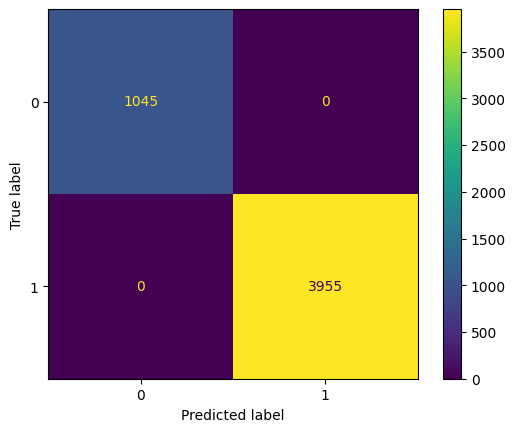

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      3955

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



['decision_tree_model.pkl']

In [10]:
symptoms = [i for i in df.columns if i != 'SEVERITY']
severity = ['SEVERITY']
# Split the data into training and testing sets
# 30% of the data will be used for testing
X_train, X_test, y_train, y_test = train_test_split(df[symptoms], df[severity], test_size=0.2, random_state=42)

# Create a Decision Tree Classifier object
dt = DecisionTreeClassifier()

# Train the model on the training set
dt.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dt.predict(X_test)

# create a function to evaluate the performance of the model
def evaluate_model(y_true, y_pred):
	# Calculate and print confusion matrix plot
	disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred))
	disp.plot()
	plt.show()
	# Calculate and print the classification report
	report = classification_report(y_true, y_pred)
	print(report)
evaluate_model(y_test, y_pred)

joblib.dump(dt, 'decision_tree_model.pkl')

Training the data using Random Forest Classifier

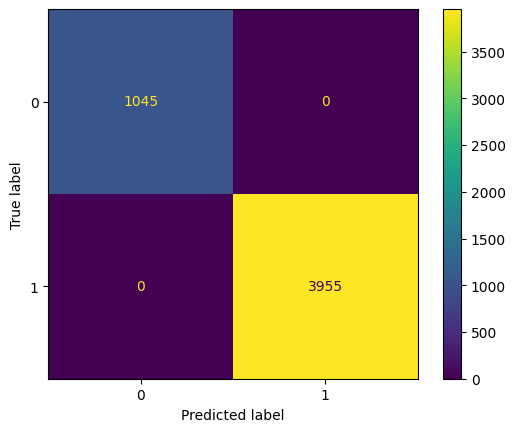

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      3955

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

Accuracy: 1.0


In [11]:
# Train the data using random classifier from scikit
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train.values.ravel())
y_pred = rf.predict(X_test)
evaluate_model(y_test, y_pred)
print(f"Accuracy: {rf.score(X_test, y_test)}")

Training the data using SVM

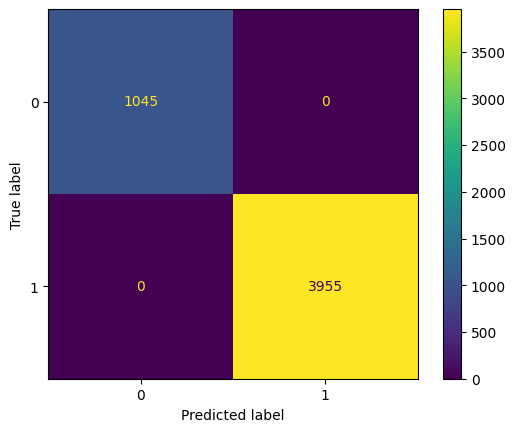

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      3955

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

Accuracy: 1.0


In [12]:
# Train the data using SVM from scikit
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(X_train, y_train.values.ravel())
y_pred = svm.predict(X_test)
evaluate_model(y_test, y_pred)
print(f"Accuracy: {svm.score(X_test, y_test)}")

In [13]:
# # Prepare your input data
# my_input = pd.DataFrame([[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]], columns=symptoms)

# # Load the trained model
# model = joblib.load('decision_tree_model.pkl')

# # Make predictions on the input data
# y_pred = model.predict(my_input)

# # Print the predicted label
from sklearn import metrics
print("Predicted label:", y_pred[0])
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Predicted label: 1
Accuracy:  1.0


Cross-fold validation

In [14]:
from sklearn.model_selection import cross_val_score

cv_amt = 10
# Perform 20-fold cross-validation on decision tree (dt)
dt_scores = cross_val_score(dt, df[symptoms], df[severity], cv=cv_amt)
rf_scores = cross_val_score(rf, df[symptoms], df[severity].values.ravel(), cv=cv_amt)
svm_scores = cross_val_score(svm, df[symptoms], df[severity].values.ravel(), cv=cv_amt)

# Print the average score and standard deviation
scores = pd.DataFrame({'ML Techniques' : ['Decision Tree', 'Random Forest', 'SVM'], 'Score' : [dt_scores.mean(), rf_scores.mean(), svm_scores.mean()], 'Standard Deviation' : [dt_scores.std(), rf_scores.std(), svm_scores.std()]})
print(scores.sort_values(by='Score', ascending=False))

      Techniques  Score  Standard Deviation
0  Decision Tree    1.0                 0.0
1  Random Forest    1.0                 0.0
2            SVM    1.0                 0.0


Export the decision tree to an image

In [15]:
from sklearn.tree import export_graphviz
import pydotplus
from io import StringIO
dt = joblib.load('decision_tree_model.pkl')

# Export the decision tree to a DOT file
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, 
    feature_names=symptoms,  
    class_names=['0','1'], 
    special_characters=True, 
    rounded=True, 
    proportion=False,
    filled=True)

# export the decision tree to a png file
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('decision_tree.png')
df.head()


,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,SHORTNESS_OF_BREATH,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,SNEEZING,SEVERITY
19453,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1
19454,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0,1
19455,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,1
19456,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0
19457,1,1,1,1,1,0,1,0,0,1,1,1,0,0,0,1
